# DSI Project 4: West Nile Virus Prediction

# Problem Statement:

Due to the recent epidemic of West Nile Virus in Chicago, we need to deploy pesticides throughout the city cost-effectively (as pesticides are expensive) and safely without causing hazard to public health.<br>
Given weather, location, testing, and spraying data, the task is to predict where and when different species of mosquitos will test positive for West Nile virus. Mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations. Success is evaluated on area under the ROC curve between the predicted probability that West Nile Virus is present and the observed outcomes.


# Data Description

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort.

There are in total 4 datasets provided:
- Training Dataset (May-Oct 2007, May-Oct 2009, Jun-Sep 2011, Jun-Sep 2013) 
- Test Dataset (Jun-Sep 2008, Jun-Oct 2010, Jun-Sep 2012, Jun-Oct 2014)
- Weather Dataset (May-Oct 2007-2014)
- Sparay Dataset (Aug-Sep 2011, Jul-Sep 2013)    

# Import Library & Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_rows', 100) # to look at more rows of data later
pd.set_option('display.max_columns', 100) # to expand columns view so that all can be seen later

In [53]:
# Load dataset
train_df = pd.read_csv('../dataset/train.csv')
test_df = pd.read_csv('../dataset/test.csv')
weather_df = pd.read_csv('../dataset/weather_final.csv')
spray_df=pd.read_csv('../dataset/spray.csv')

# EDA & Cleaning Data

In [3]:
# Print shape of dataset
print(train_df.shape)
print(test_df.shape)

(10506, 12)
(116293, 11)


There are more test data (92%) than training data (8%). Imbalance Data?

In [4]:
# Print columns
print(train_df.columns)
print(test_df.columns)

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')
Index(['Id', 'Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy'],
      dtype='object')


In [5]:
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [6]:
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [7]:
print(train_df[train_df.duplicated()].count())

Date                      813
Address                   813
Species                   813
Block                     813
Street                    813
Trap                      813
AddressNumberAndStreet    813
Latitude                  813
Longitude                 813
AddressAccuracy           813
NumMosquitos              813
WnvPresent                813
dtype: int64


There are 813 duplicate observations in train dataset due to the test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another row in the dataset.(In short, the number of mosquito of each row are capped at 50).

In [8]:
print(test_df[test_df.duplicated()].count())

Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64


There is no duplicate observations in test dataset as there's no 'NumMosquitos' in test dataset.

In [9]:
train_df.groupby(by=['Date','Address','Species','WnvPresent']).sum()

Block  \
Date       Address                                            Species                WnvPresent          
2007-05-29 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS/RESTUANS 0              11   
                                                              CULEX RESTUANS         0              11   
           1100 South Peoria Street, Chicago, IL 60608, USA   CULEX RESTUANS         0              11   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0              11   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0              15   
           1500 West Webster Avenue, Chicago, IL 60614, USA   CULEX RESTUANS         0              15   
           1700 West 95th Street, Chicago, IL 60643, USA      CULEX RESTUANS         0              17   
           2100 North Stave Street, Chicago, IL 60647, USA    CULEX PIPIENS/RESTUANS 0              21   
           2200 North Cannon Drive, Chicago, IL 60614, USA    CULEX PIPIENS/RESTUANS 0              22   
                                                              CULEX RESTUANS         0              22   
           2200 West 113th Street, Chicago, IL 60643, USA     CULEX PIPIENS/RESTUANS 0              22   
                                                              CULEX RESTUANS         0              22   
           2200 West 89th Street, Chicago, IL 60643, USA      CULEX PIPIENS          0              22   
                                                              CULEX RESTUANS         0              22   
           2500 West Grand Avenue, Chicago, IL 60654, USA     CULEX RESTUANS         0              25   
           4100 North Oak Park Avenue, Chicago, IL 60634, USA CULEX PIPIENS/RESTUANS 0              41   
                                                              CULEX RESTUANS         0              41   
           6200 North Mandell Avenue, Chicago, IL 60646, USA  CULEX RESTUANS         0              62   
           6500 North Oak Park Avenue, Chicago, IL 60631, USA CULEX PIPIENS/RESTUANS 0              65   
           7500 North Oakley Avenue, Chicago, IL 60645, USA   CULEX PIPIENS/RESTUANS 0              75   
           7900 West Foster Avenue, Chicago, IL 60656, USA    CULEX PIPIENS/RESTUANS 0              79   
                                                              CULEX RESTUANS         0              79   
           8900 South Carpenter Street, Chicago, IL 60620,... CULEX RESTUANS         0              89   
           North Streeter Drive, Chicago, IL 60611, USA       CULEX PIPIENS/RESTUANS 0              53   
                                                              CULEX RESTUANS         0              53   
2007-06-05 1100 Roosevelt Road, Chicago, IL 60608, USA        CULEX PIPIENS          0              11   
                                                              CULEX PIPIENS/RESTUANS 0              11   
                                                              CULEX RESTUANS         0              11   
           1100 South State Street, Chicago, IL 60605, USA    CULEX PIPIENS/RESTUANS 0              11   
           1100 West Chicago Avenue, Chicago, IL 60642, USA   CULEX RESTUANS         0              11   
           1400 North Sacramento Avenue, Chicago, IL 60622... CULEX RESTUANS         0              14   
           1500 North Long Avenue, Chicago, IL 60651, USA     CULEX RESTUANS         0              15   
           1500 West Granville Avenue, Chicago, IL 60660, USA CULEX PIPIENS/RESTUANS 0              15   
           1500 West Webster Avenue, Chicago, IL 60614, USA   CULEX PIPIENS          0              15   
                                                              CULEX PIPIENS/RESTUANS 0              15   
                                                              CULEX RESTUANS         0              15   
           1700 West 95th Street, Chicago, IL 60643, USA      CULEX P

We define unique trap observation by grouping 'Date','Address','Species','WnvPresent'.<br>
We are not considering 'NumMosquitos' as our feature as there's no ''NumMosquitos' found in test dataset.<br>There are in total 8610 unique trap observations in train dataset.

In [10]:
# Drop duplicates
train_df.drop_duplicates(subset=['Date','Address','Species','Trap','Block','WnvPresent'],inplace=True)
train_df.reset_index(inplace=True)

In [11]:
train_df.shape

(8610, 13)

In [12]:
# Check which mozzies spread WNV
train_df[train_df['WnvPresent'] == 1]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS'],
      dtype=object)

From train dataset it can be observed that WNV is only present in the following 3 species of Mosquitos:
- CULEX PIPIENS/RESTUANS
- CULEX PIPIENS
- CULEX RESTUANS

In [13]:
# Check if there's overlap
train_df[train_df['WnvPresent'] == 0]['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

However, the presence of any single species does not mandate the presence of WNV. 

In [14]:
# Find probability of ocurrence for each mosquito
prob_1 = train_df[train_df['Species'] == 'CULEX PIPIENS/RESTUANS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX PIPIENS/RESTUANS']['WnvPresent'].count()
prob_2 = train_df[train_df['Species'] == 'CULEX PIPIENS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX PIPIENS']['WnvPresent'].count()
prob_3 = train_df[train_df['Species'] == 'CULEX RESTUANS']['WnvPresent'].sum()/train_df[train_df['Species'] == 'CULEX RESTUANS']['WnvPresent'].count()

In [15]:
# Ordinal encode species
ord_list = []
for i in train_df['Species']:
    if i == 'CULEX PIPIENS/RESTUANS':
        ord_list.append(prob_1)
    elif i == 'CULEX PIPIENS':
        ord_list.append(prob_2)
    elif i == 'CULEX RESTUANS':
        ord_list.append(prob_3)
    else:
        ord_list.append(0)

train_df['Species_Enc'] = ord_list

In [16]:
# Ordinal encode species
ord_list = []
for i in test_df['Species']:
    if i == 'CULEX PIPIENS/RESTUANS':
        ord_list.append(2)
    elif i == 'CULEX PIPIENS':
        ord_list.append(3)
    elif i == 'CULEX RESTUANS':
        ord_list.append(1)
    else:
        ord_list.append(0)

test_df['Species_Enc'] = ord_list

In [17]:
# One-hot encode mozzies that spread WNV
train_species = pd.get_dummies(train_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]
test_species = pd.get_dummies(test_df['Species'])[['CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS']]

Based on earlier observation on train dataset, only 'CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS' are found to carry WNV.<br>
We one hot encode these 3 species and for other species that does not fall in any of the 3 categories, it will be encoded as all zeroes (Other Species).

In [18]:
train_df = pd.concat([train_df,train_species],axis=1,sort=False)
test_df = pd.concat([test_df,test_species],axis=1,sort=False)

In Weather dataset, there are 2 weather stations that records weather conditions daily.<br>

We need to identify which weather station(1 or 2) is closest to each trap, and join the weather data based on the date of observation.

Distance is calculated by euclidean distance between weather stations and traps coordinate.

In [19]:
# Calculate euclidean distance of weather station from city and determine which station is nearest
# This is calculated using pythagoras theorem  
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
train_df['diststat1'] = np.sqrt((train_df['Latitude'] - 41.995) ** 2 + (train_df['Longitude'] - (-87.933)) ** 2)
train_df['diststat2'] = np.sqrt((train_df['Latitude'] - 41.786) ** 2 + (train_df['Longitude'] - (-87.752)) ** 2)
train_df['Station'] = [2 if train_df['diststat1'][i] > train_df['diststat2'][i] else 1 for i in range(train_df.shape[0])]
train_df.head(2)


,index,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent,Species_Enc,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0.057707,1,0,0,0.138026,0.17566,1
1,1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0.019925,0,0,1,0.138026,0.17566,1


In [20]:
# Apply for test data set

test_df['diststat1'] = np.sqrt((test_df['Latitude'] - 41.995) ** 2 + (test_df['Longitude'] - (-87.933)) ** 2)
test_df['diststat2'] = np.sqrt((test_df['Latitude'] - 41.786) ** 2 + (test_df['Longitude'] - (-87.752)) ** 2)
test_df['Station'] = [2 if test_df['diststat1'][i] > test_df['diststat2'][i] else 1 for i in range(test_df.shape[0])]
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,Species_Enc,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,2,1,0,0,0.138026,0.17566,1
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0,0,1,0.138026,0.17566,1
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,3,0,1,0,0.138026,0.17566,1
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0,0.138026,0.17566,1
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0,0,0,0.138026,0.17566,1


In [21]:
# Feature engineer to add a new column 'dateofyear', which is the day within a year.
train_df['dateofyear'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d').dt.dayofyear
test_df['dateofyear'] = pd.to_datetime(test_df['Date'], format='%Y-%m-%d').dt.dayofyear

In [22]:
# Merged weather and train/test to one dataframe
train_weather_df = pd.merge(train_df,weather_df,on=['Station','Date'])
train_weather_df.drop(axis=1,columns=['index'],inplace=True)
train_weather_df.head()
train_weather_df.to_csv('../dataset/train_weather_csv')

In [23]:
test_weather_df = pd.merge(test_df,weather_df,on=['Station','Date'])
# test_weather_df.drop(axis=1,columns=['index'],inplace=True)
test_weather_df.head()
train_weather_df.to_csv('../dataset/test_weather_csv')

In [24]:
train_weather_df.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
Species_Enc               float64
CULEX PIPIENS/RESTUANS      uint8
CULEX PIPIENS               uint8
CULEX RESTUANS              uint8
diststat1                 float64
diststat2                 float64
Station                     int64
dateofyear                  int64
Tmax                        int64
Tmin                        int64
Tavg                      float64
Depart                    float64
DewPoint                    int64
WetBulb                   float64
Heat                      float64
Cool                      float64
Sunrise                     int64
Sunset        

In [25]:
# Rearrange Column Name
col_at_end=['WnvPresent']
train_weather_df=train_weather_df[[c for c in train_weather_df if c not in col_at_end]+
                                [c for c in col_at_end]]
print(train_weather_df.shape)
train_weather_df.head(2)

(8610, 39)


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,Species_Enc,CULEX PIPIENS/RESTUANS,CULEX PIPIENS,CULEX RESTUANS,diststat1,diststat2,Station,dateofyear,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Year,Month,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0.057707,1,0,0,0.138026,0.17566,1,149,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1,0.019925,0,0,1,0.138026,0.17566,1,149,88,60,74.0,10.0,58,65.0,0.0,9.0,421,1917,BR HZ,0.0,29.39,30.11,5.8,18,6.5,2007,5,0


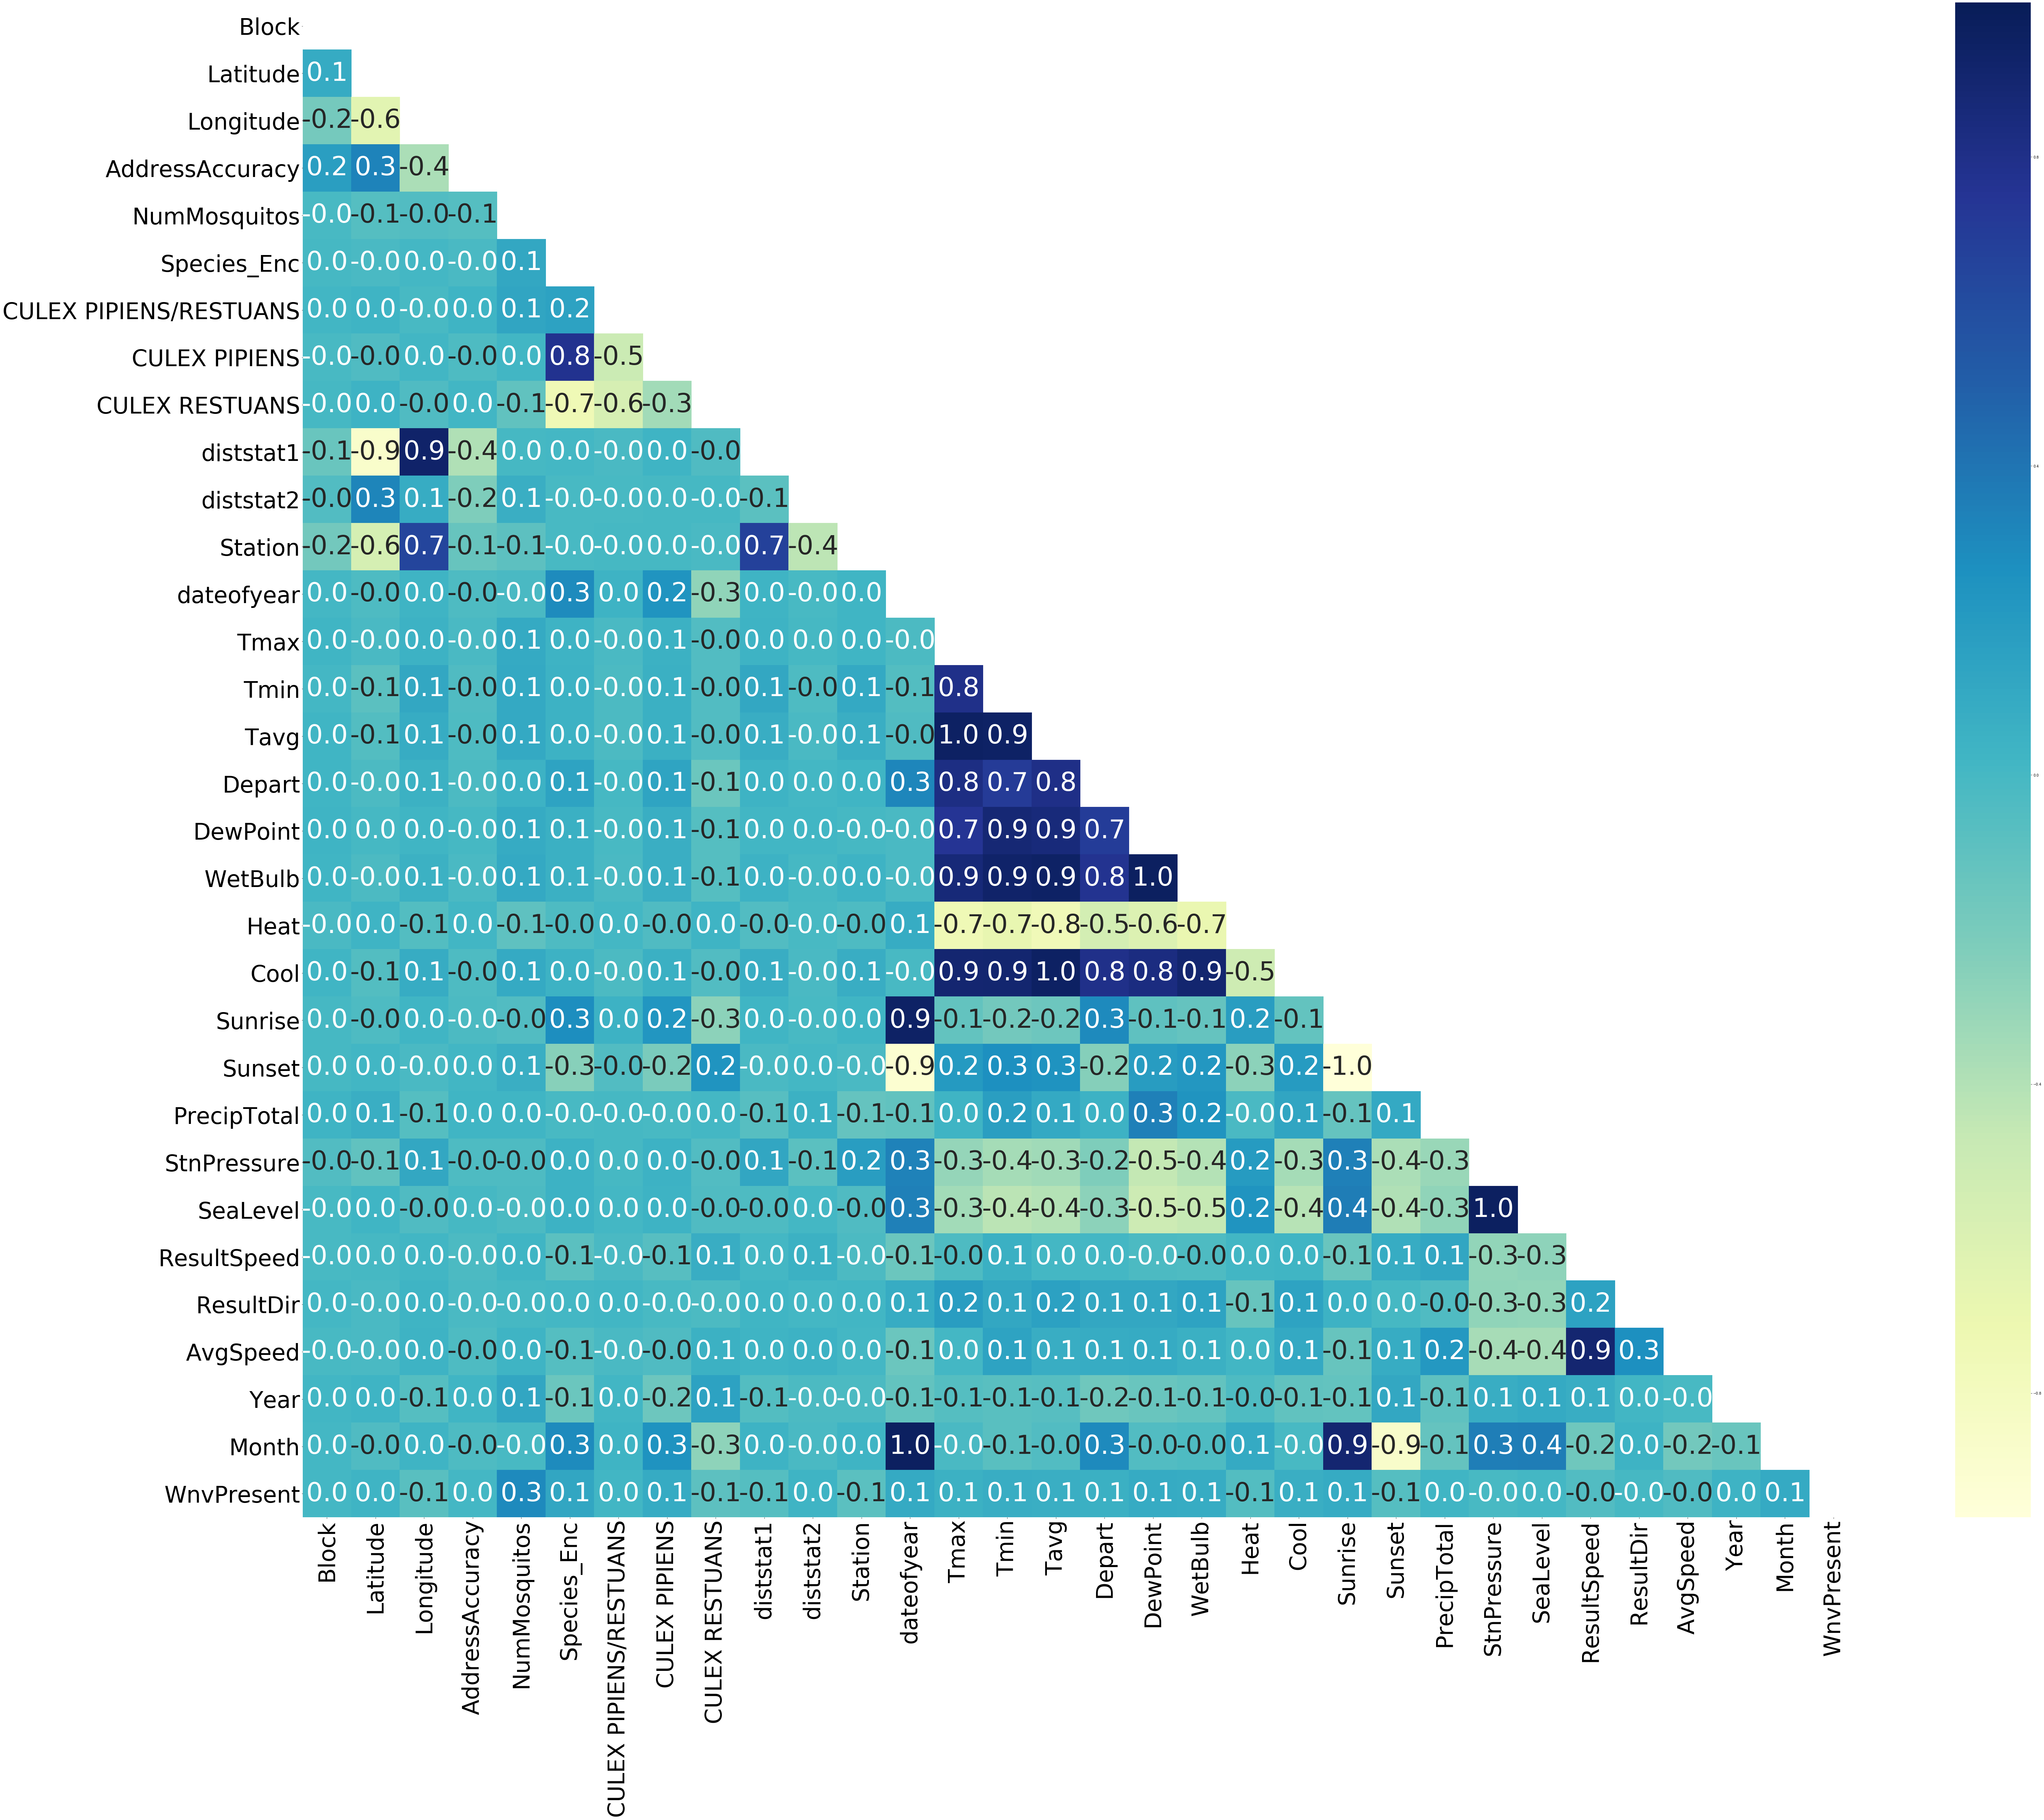

In [51]:
# Find out correlation in train_weather_df databse
train_weather_df_corr=train_weather_df.corr()

# Plot Heat Map to check correlation of features
fix, ax = plt.subplots(figsize=(100,80))
mask = np.zeros_like(train_weather_df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(train_weather_df_corr, mask=mask, cmap='YlGnBu',ax=ax,annot=True,fmt='.1f',annot_kws={"size":75})
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=65, rotation = 90)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=65,rotation = 360);

Factors that influences No of Mozz

In [64]:
# Correlation with output variable- NumMosquitos
cor_target = abs(train_weather_df_corr["NumMosquitos"])

In [69]:
#Selecting highly correlated features- NumMosquitos
relevant_features_mozz = cor_target[cor_target>0.01].sort_values(ascending=False)
print(relevant_features_mozz.count())
relevant_features_mozz

29


NumMosquitos              1.000000
WnvPresent                0.298589
CULEX PIPIENS/RESTUANS    0.128822
Year                      0.119366
Species_Enc               0.117031
Tavg                      0.111130
CULEX RESTUANS            0.109848
Tmin                      0.108633
WetBulb                   0.108251
Tmax                      0.101301
Cool                      0.098754
Heat                      0.098538
Station                   0.094629
DewPoint                  0.094003
diststat2                 0.068494
Sunset                    0.065781
AddressAccuracy           0.060057
Latitude                  0.059297
Depart                    0.049141
Longitude                 0.047254
Sunrise                   0.042097
StnPressure               0.033742
AvgSpeed                  0.027851
PrecipTotal               0.024069
ResultSpeed               0.019641
SeaLevel                  0.019262
CULEX PIPIENS             0.013715
dateofyear                0.012372
Month               

In [75]:
factor_mozz=['Tavg','Tmin','Tmax','Depart','Cool','Heat','WetBulb','DewPoint','StnPressure','AvgSpeed','PrecipTotal','ResultSpeed','SeaLevel','Sunset','Sunrise','Station']
len(factor_mozz)

16

In [61]:
# train_weather_df['Date']=pd.to_datetime(train_weather_df['Date'])
# train_weather_df.dtypes

In [62]:
# train_weather_df.head(3)

# Spray

In [55]:
spray_df.head()

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157
3,2011-08-29,6:57:28 PM,42.390637,-88.089158
4,2011-08-29,6:57:38 PM,42.390410,-88.088858


In [27]:
feat = ['dateofyear','Latitude','Longitude','AddressAccuracy','CULEX PIPIENS/RESTUANS','CULEX PIPIENS','CULEX RESTUANS','Heat','Cool','WetBulb','PrecipTotal','Sunrise','Sunset','Tmin','Tmax']

X_subset = train_weather_df[feat]
y = train_weather_df['WnvPresent']
X_kaggle_subset = test_weather_df[feat]

In [28]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_train_poly = poly.fit_transform(X_subset)
X_kaggle_poly = poly.fit_transform(X_kaggle_subset)

In [29]:
poly_train = pd.DataFrame(X_train_poly, columns = poly.get_feature_names(X_subset.columns),index=train_weather_df.index)
poly_kaggle = pd.DataFrame(X_kaggle_poly, columns = poly.get_feature_names(X_kaggle_subset.columns),index=test_weather_df.index)

In [30]:
poly_train.columns

Index(['dateofyear', 'Latitude', 'Longitude', 'AddressAccuracy',
       'CULEX PIPIENS/RESTUANS', 'CULEX PIPIENS', 'CULEX RESTUANS', 'Heat',
       'Cool', 'WetBulb',
       ...
       'PrecipTotal Sunrise', 'PrecipTotal Sunset', 'PrecipTotal Tmin',
       'PrecipTotal Tmax', 'Sunrise Sunset', 'Sunrise Tmin', 'Sunrise Tmax',
       'Sunset Tmin', 'Sunset Tmax', 'Tmin Tmax'],
      dtype='object', length=120)

In [31]:
feature_list = ['dateofyear',
                'Latitude', 
                'Longitude',
                'CULEX PIPIENS/RESTUANS',
                'CULEX PIPIENS',
                'CULEX RESTUANS',
                'dateofyear CULEX PIPIENS/RESTUANS',
                'dateofyear CULEX PIPIENS',
                'dateofyear CULEX RESTUANS',
                'Latitude CULEX PIPIENS/RESTUANS',
                'Latitude CULEX PIPIENS',
                'Latitude CULEX RESTUANS',
                'Longitude CULEX PIPIENS/RESTUANS', 
                'Longitude CULEX PIPIENS',
                'Longitude CULEX RESTUANS',
               'Heat','Cool','WetBulb','PrecipTotal','Sunrise','Sunset','Tmin','Tmax']


X = poly_train[feature_list]
y = train_weather_df['WnvPresent']
X_kaggle = poly_kaggle[feature_list]

In [32]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X)
X_kaggle_scaled = ss.fit_transform(X_kaggle)

In [33]:
lr = LogisticRegression(solver='lbfgs')

X_train, X_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,stratify=y,random_state=42)

In [34]:
lr.fit(X_scaled,y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
lr.score(X_scaled,y)

0.9469221835075493

In [36]:
pred = lr.predict(X_kaggle_scaled)

In [37]:
pred.sum()

15105

In [38]:
len(pred)

116293

In [39]:
predictions = lr.predict(X_kaggle_scaled)
pred_df = pd.DataFrame({'Id':test_weather_df['Id'],'WnvPresent': predictions})
pred_df.set_index('Id',inplace=True)
pred_df.to_csv('../predictions3.csv')

In [40]:
X_train, X_test, y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,stratify=y,random_state=42)
gs = GridSearchCV(lr,{},scoring='roc_auc',cv=3)

In [41]:
gs.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=0)

In [42]:
gs.best_score_

0.76892235577207

In [43]:
gs.fit(X_scaled,y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring='roc_auc',
             verbose=0)

In [44]:
gs.best_score_

0.6724300061667441

In [45]:
pred2 = gs.predict(X_kaggle_scaled)

In [46]:
pred2.sum()

15105